In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import os
os.makedirs('models', exist_ok=True)

In [15]:
from sklearn.metrics import root_mean_squared_error

In [2]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("my-experiment")

2025/07/15 23:32:28 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/15 23:32:28 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-Experiment Tracking/mlruns/1', creation_time=1752018549946, experiment_id='1', last_update_time=1752018549946, lifecycle_stage='active', name='my-experiment', tags={}>

In [3]:
path1 = './yellow_tripdata_2024-01.parquet'
path2 = './yellow_tripdata_2024-02.parquet'

In [4]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    #df.head()
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # filter
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    
    df[categorical] = df[categorical].astype(str) #int -> str
    
    return df


In [5]:
df_train = read_dataframe(path1).sample(10000, random_state=1)
df_val = read_dataframe(path2).sample(10000, random_state=1)

In [6]:
#td = df.duration.iloc[0]
#td.total_seconds()
#df.duration.describe(percentiles=[0.95, 0.98, 0.99])
#numerical = ['trip_distance']
#df[categorical].dtypes
#len(df_train) == len(df_val)

In [7]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [8]:
#categorical = ['PULocationID', 'DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer() #DictVectorizer는 딕셔너리 형태의 데이터를 머신러닝 모델이 사용할 수 있는 행렬(벡터)로 변환합니다.

#DataFrame에서 범주형(categorical)과 수치형(numerical) 컬럼만 선택해, 각 행을 딕셔너리로 변환합니다.
#결과는 딕셔너리의 리스트가 됩니다. (예: [{'col1': val1, 'col2': val2, ...}, ...])
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

#fit_transform은 학습과 변환을 동시에 수행합니다.
#X_train은 변환된 특성 행렬(2차원 배열, sparse matrix)입니다.
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

#예측하고자 하는 목표값(여기서는 'duration' 컬럼)을 y_train에 저장합니다.
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values



In [9]:
#선형회귀 모델을 생성하고, X_train(특성)과 y_train(목표값)으로 학습시킵니다.
lr = LinearRegression()
lr.fit(X_train, y_train)

#학습된 모델로 X_train에 대한 예측값을 구합니다.
y_pred = lr.predict(X_train)

#회귀 문제에서 예측값과 실제값의 차이를 제곱해 평균을 낸 값(MSE, 평균제곱오차)을 계산
mean_squared_error(y_train, y_pred)

14.595657517143144

/tmp/ipykernel_2968/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2968/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


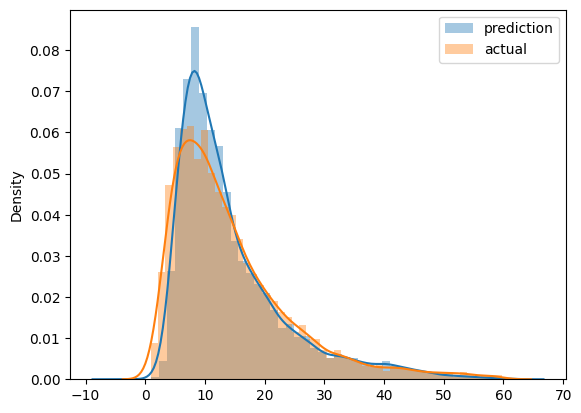

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [18]:


with mlflow.start_run():
    mlflow.set_tag("dev", "josh")
    mlflow.log_param("train-data-path", path1)
    mlflow.log_param("val-data-path", path2)
    
    alpha = 0.001
    mlflow.log_param("alpha", alpha)
    lr = Ridge(alpha) 
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)
    rmse = root_mean_squared_error(y_train, y_pred)
    mlflow.log_metric("rmse", rmse)

In [ ]:
#'models/lin_reg.bin' 파일을 바이너리 쓰기 모드('wb')로 엽니다.
# pickle.dump((dv, lr), f_out)는 dv와 lr 객체를 튜플로 묶어 파일에 저장합니다.
#with open('models/lin_reg.bin', 'wb') as f_out:
#    pickle.dump((dv, lr), f_out)    

In [19]:
import xgboost as xgb
# 최적의 hyper parameter set을 찾기 위해 Bayesian Optimization을 사용하는 라이브러리
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("models", "xgboost")
        mlflow.log_param(params)
        booster = xgb.train(
            params=params,
            dtrain=train
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )

        # 예측 및 RMSE 계산
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        
        # 메트릭 기록
        mlflow.log_metric("rmse", rmse)
        return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
# seasrch_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
    